In [16]:
import h5py
import jax.numpy as jnp
import numpy as np
import healpy as hp
from functools import partial

# check gaussian construtction and projection

In [2]:
filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
f = h5py.File(filename, "r")
dataset_grid = f['parameters']['grid']

In [252]:
nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area
xsize = 80  # width of figure in pixels
size = 10 # Size of square in degrees
reso = size * 60 / xsize
master_key = jax.random.PRNGKey(0)

In [295]:
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0'],
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T

nb_of_projected_map = 1
master_key = jax.random.PRNGKey(6)
key, master_key = jax.random.split(master_key)
params = cosmo_parameters[0]
path_string = '/gpfsdswork/dataset/' + dataset_grid['path_par'][0].decode('utf-8').replace('CosmoGrid', 'CosmoGridV1').replace('raw', 'stage3_forecast')
for j in range(1): 
    filename = path_string + 'perm_000' + str(j) 
    filename_baryon = filename + '/projected_probes_maps_baryonified512.h5'
    filename_withouth_baryon = filename + '/projected_probes_maps_nobaryons512.h5'
    sim_with_baryon = h5py.File(filename_baryon, "r")
    sim_without_baryon = h5py.File(filename_withouth_baryon, "r")


    # keeping only last tomo bins
    nbody_map_without_baryon = np.array(sim_without_baryon['kg']['stage3_lensing{}'.format(4)])
    nbody_map_with_baryon_and_ia =  np.array(sim_with_baryon['kg']['stage3_lensing{}'.format(4)]) + np.array(sim_with_baryon['ia']['stage3_lensing{}'.format(4)])

    # building gaussian map
    lmax = 3*nside - 1  
    power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)
    z = np.random.randn(hp.nside2npix(nside)) * np.sqrt(scaling_factor) 
    power_spectrum_noise =  hp.sphtfunc.anafast(z, lmax = lmax)
    power_spectrum_target = power_spectrum_nbody_map / power_spectrum_noise
    alm_hp = hp.map2alm(z, lmax = lmax)
    alm = hp.sphtfunc.almxfl(alm_hp, np.sqrt(power_spectrum_target))
    gaussian_map = hp.alm2map(alm, nside, lmax = lmax)

    # projection
    key1, key2 = jax.random.split(key)
    lon = jax.random.randint(key1,(nb_of_projected_map,),-180, 180)
    lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
    for k in range(nb_of_projected_map):
        proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
        projection_nbody_w_baryon_ia = proj.projmap(nbody_map_with_baryon_and_ia, vec2pix_func=partial(hp.vec2pix, nside))
        projection_nbody = proj.projmap(nbody_map_without_baryon, vec2pix_func=partial(hp.vec2pix, nside))
        projection_gaussian = proj.projmap(gaussian_map, vec2pix_func=partial(hp.vec2pix, nside))

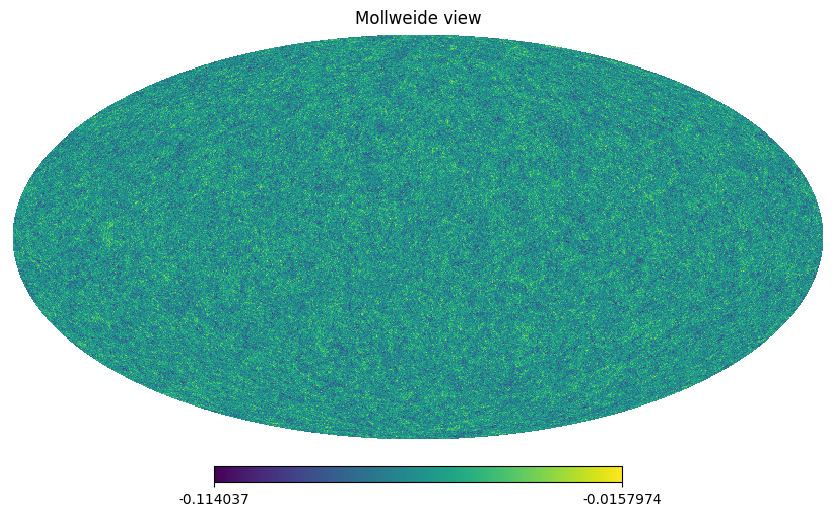

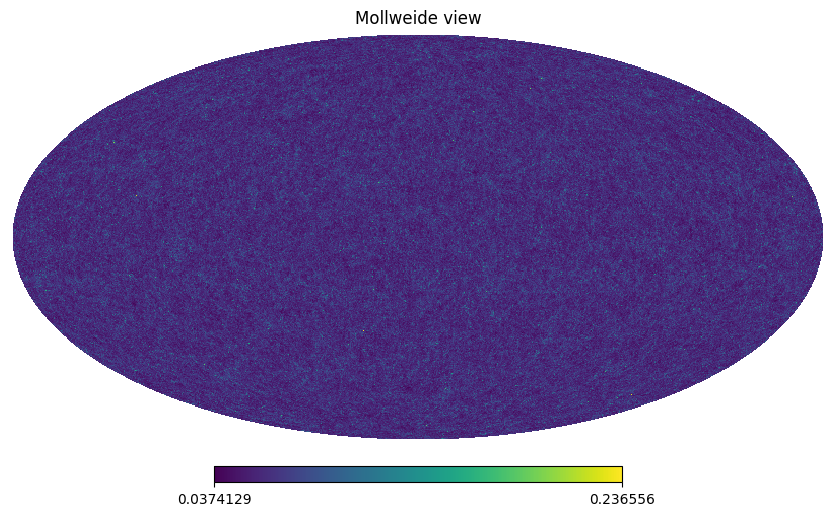

In [296]:
hp.mollview(gaussian_map)
hp.mollview(nbody_map_without_baryon)

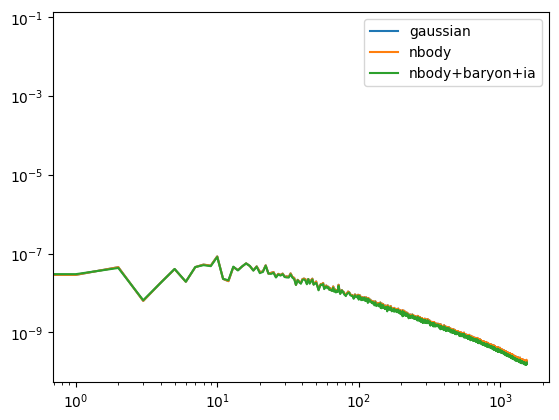

In [261]:
import matplotlib.pyplot as plt 
i = 0
power_spectrum_gaussian_map = hp.sphtfunc.anafast(gaussian_map, lmax = lmax)
power_spectrum_nbody_w_baryon_ia_map = hp.sphtfunc.anafast(nbody_map_with_baryon_and_ia, lmax = lmax)
power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)
plt.loglog(power_spectrum_gaussian_map[i:], label = 'gaussian')
plt.loglog(power_spectrum_nbody_map[i:], label = 'nbody')
plt.loglog(power_spectrum_nbody_w_baryon_ia_map[i:], label = 'nbody+baryon+ia')
plt.legend()

In [262]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
map_size=10

ell = ConvergenceMap(projection_gaussian, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps = ConvergenceMap(projection_gaussian, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1]

ell2 = ConvergenceMap(projection_nbody, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps2 = ConvergenceMap(projection_nbody, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1]

ell3 = ConvergenceMap(projection_nbody_w_baryon_ia, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps3 = ConvergenceMap(projection_nbody_w_baryon_ia, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1]

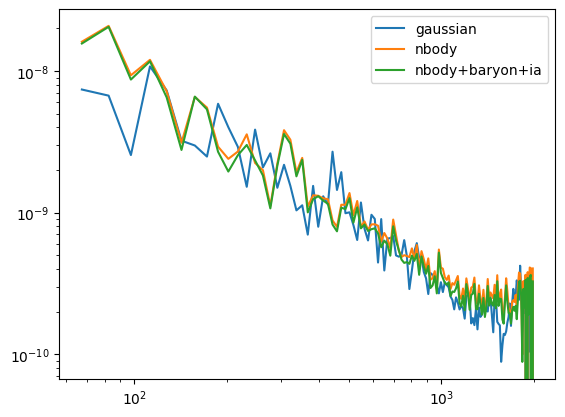

In [263]:
plt.loglog(ell,ps, label ='gaussian')
plt.loglog(ell2, ps2, label ='nbody')
plt.loglog(ell3, ps3, label ='nbody+baryon+ia')
plt.legend()

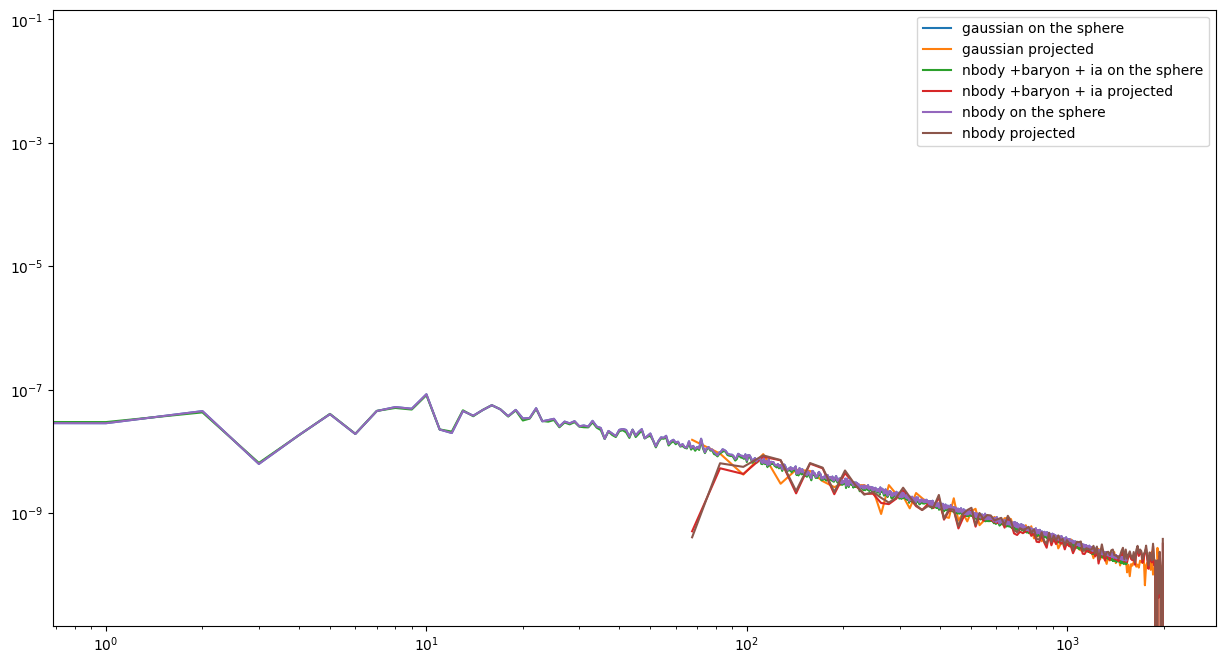

In [183]:
import matplotlib.pyplot as plt 
i = 0
plt.figure(figsize=(15,8))
power_spectrum_gaussian_map = hp.sphtfunc.anafast(gaussian_map, lmax = lmax)
plt.loglog(power_spectrum_gaussian_map[i:], label = 'gaussian on the sphere')
plt.loglog(ell, ps[i:], label = 'gaussian projected')
power_spectrum_nbody_w_baryon_ia_map = hp.sphtfunc.anafast(nbody_map_with_baryon_and_ia, lmax = lmax)
plt.loglog(power_spectrum_nbody_w_baryon_ia_map[i:], label = 'nbody +baryon + ia on the sphere')
plt.loglog(ell, ps3[i:], label = 'nbody +baryon + ia projected')
plt.loglog(power_spectrum_nbody_map[i:], label = 'nbody on the sphere')
plt.loglog(ell, ps2[i:], label = 'nbody projected')
plt.legend()

# to see where the projection is 

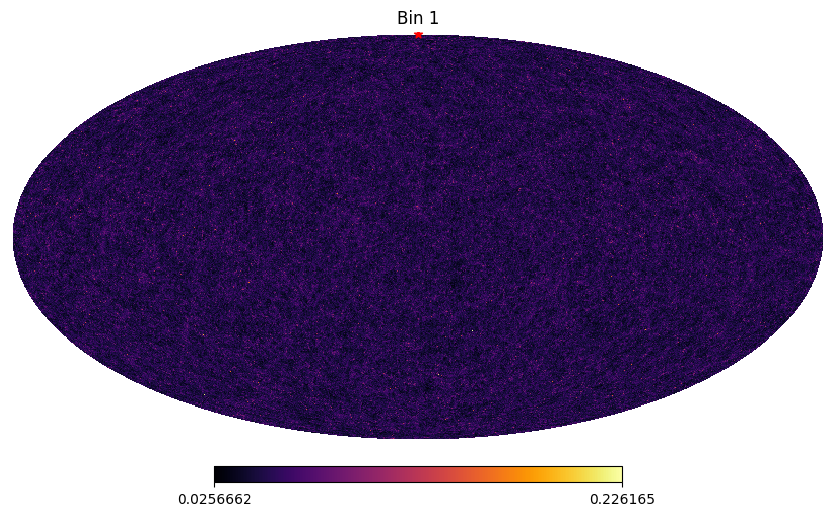

In [33]:
nside = 512
lon = 180
lat = 90

# Convert the flat array to a Healpix map
healpix_map = hp.pixelfunc.ud_grade(nbody_map_with_baryon_and_ia, nside_out=nside)

# Plotting the Healpix map on a sphere
hp.mollview(healpix_map, title='Bin {}'.format(i),cmap='inferno', nest=False)

# # Display the plot
hp.projscatter(lon, lat, lonlat=True, marker='*', color='red', label='Patch Location')
# hp.graticule()

# checking redshift distribution 

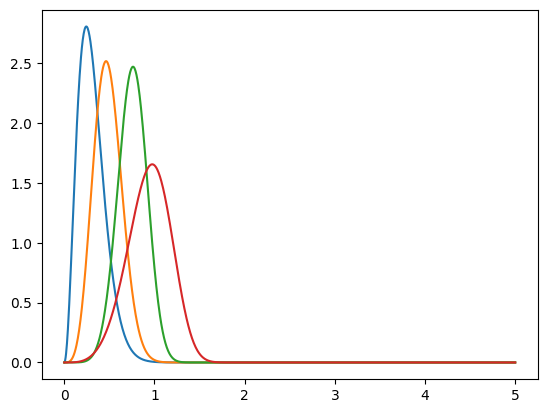

In [42]:
import numpy as np

for i in range(1,5):
    with open(f'./vae/nz/nz_stage3_{i}.txt', 'r') as file:
        lines = file.readlines()

    # Parse the text data into a list of lists (assuming numeric data separated by spaces or commas)
    data = []
    for line in lines:
        line_data = line.strip().split()  # Assuming space-separated data
        # If the data is comma-separated, use the following line instead:
        # line_data = line.strip().split(',')
        data.append([float(x) for x in line_data])  # Convert strings to floats

    # Convert the list of lists into a NumPy array
    nz = np.array(data)
    plt.plot(nz[:,0], nz[:,1])

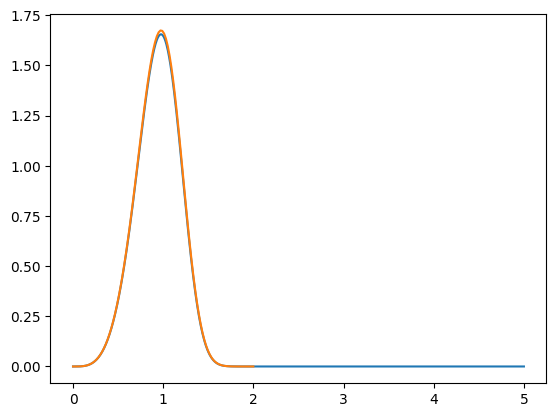

In [44]:
# lets try to match the distribution of bins 4 
pz4 = jc.redshift.smail_nz(3.53, 4.49, 1.03,gals_per_arcmin2=10/4, zmax=2.)
z = jnp.linspace(0,2,100)

plt.plot(nz[:,0],nz[:,1])
plt.plot(z,pz4.pz_fn(z)*4.)

In [ ]:
# oook so 
from jax_cosmo.redshift import redshift_distribution
# @register_pytree_node_class
class smail_nz(redshift_distribution):
    """Defines a smail distribution with these arguments
    Parameters:
    -----------
    a:

    b:

    z0:

    gals_per_arcmin2: number of galaxies per sq arcmin
    """

    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * np.exp(-((z / z0) ** b))*4

# checking dataset and noise augmentation 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import jax.numpy as jnp

sigma_e = 0.26
galaxy_density = 10 / 4
field_size = size = 10
field_npix = xsize = 80
nside = 512
reso = size * 60 / xsize
nbins = 1
dim = 6

def augmentation_noise(
        example, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=256
    ):
        x = example["map_gaussian"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"maps": x, "theta": example["theta"]}
    

def augmentation_flip(example):
    x = tf.expand_dims(example["maps"], -1)
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    return {"maps": x, "theta": example["theta"]}

def rescale_h(example): 
    x = example['theta']
    index_to_update = 3
    x = tf.tensor_scatter_nd_update(x, [[index_to_update]], [x[index_to_update] / 100])
    return {"maps": example["maps"], "theta": x}

def augmentation(example):
    return rescale_h(
        augmentation_flip(
            augmentation_noise(
                example=example,
                sigma_e=sigma_e,
                galaxy_density=galaxy_density,
                field_size=field_size,
                field_npix=field_npix,
            )
        )
    )


ds_tr = tfds.load("CosmogridGridDataset/grid", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
# ds_tr = ds_tr.map(augmentation)
ds_tr = ds_tr.batch(5)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

2024-04-27 19:39:10.248753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 19:39:10.586382: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/gpfslocalsup/pub/anaconda-py3/2022.05/envs/tensorflow-gpu-2.11.0+py3.10.8/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-27 1

In [2]:
test = next(ds_train)

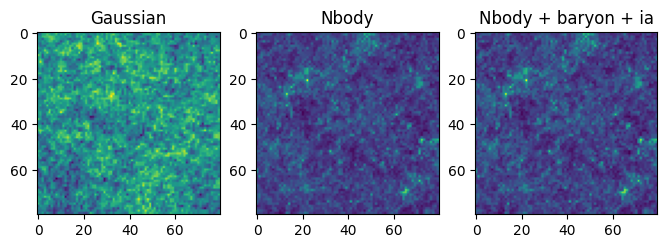

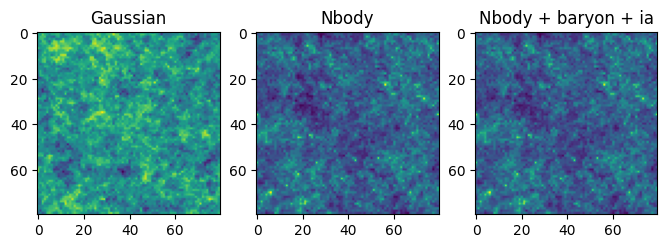

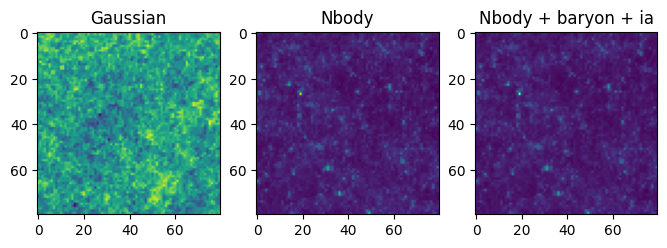

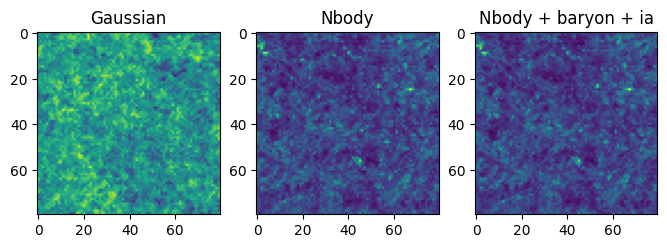

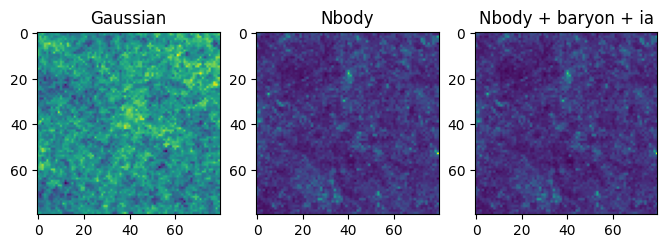

In [3]:
import matplotlib.pyplot as plt

for i in range(5): 
    plt.figure(figsize = (8,4))
    plt.subplot(1,3,1)
    plt.imshow(test['map_gaussian'][i]);plt.title('Gaussian')
    plt.subplot(1,3,2)
    plt.imshow(test['map_nbody'][i]);plt.title('Nbody')
    plt.subplot(1,3,3)
    plt.imshow(test['map_nbody_w_baryon_ia'][i]);plt.title('Nbody + baryon + ia')
    plt.show()
    
    
# supposed to see the same structures in gaussian map?

In [60]:
def augmentation_noise(
        example, sigma_e=sigma_e, galaxy_density=galaxy_density, field_size=field_size, field_npix=field_npix
    ):
        x = example["map_gaussian"]
        x += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )
        
        y = example["map_nbody"]
        y += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )
        
        z = example['map_nbody_w_baryon_ia']
        z += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )

        return {"map_gaussian": x, "map_nbody": y, 'map_nbody_w_baryon_ia':z, 'theta':example['theta']}
    
ds_tr = tfds.load("CosmogridGridDataset/grid", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation_noise)
ds_tr = ds_tr.batch(500)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

In [61]:
ex = next(ds_train)

In [62]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

nb = 1 # because it is not at fixed cosmo

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
map_size=10

ell = ConvergenceMap(ex['map_gaussian'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps = []
for i in range(nb):
    ps.append(ConvergenceMap(ex['map_gaussian'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps = np.mean(ps, axis =0)

ell2 = ConvergenceMap(ex['map_nbody'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps2 = []
for i in range(nb):
    ps2.append(ConvergenceMap(ex['map_nbody'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps2 = np.mean(ps2, axis =0)

ell3 = ConvergenceMap(ex['map_nbody_w_baryon_ia'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps3 = []
for i in range(nb):
    ps3.append(ConvergenceMap(ex['map_nbody_w_baryon_ia'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps3 = np.mean(ps3, axis =0)

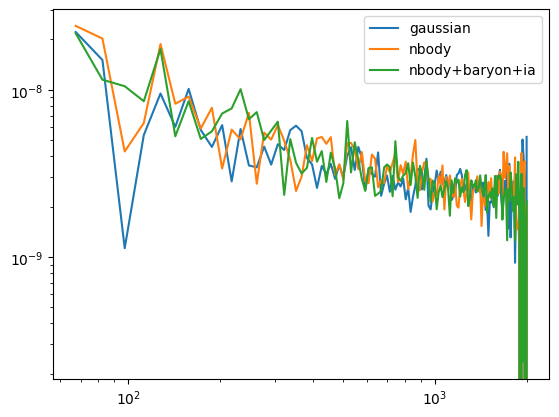

In [63]:
plt.loglog(ell,ps, label ='gaussian')
plt.loglog(ell2, ps2, label ='nbody')
plt.loglog(ell3, ps3, label ='nbody+baryon+ia')
plt.legend()

In [66]:
import jax_cosmo as jc
# filename = '/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5'
# f = h5py.File(filename, "r")
# dataset_grid = f['parameters']['fiducial']

# power spectrum from theory
cosmo = jc.Planck15(
    Omega_c=ex['theta'][0][0] - ex['theta'][0][-1],
    Omega_b=ex['theta'][0][-1],
    h=ex['theta'][0][3] / 100,
    n_s=ex['theta'][0][4],
    sigma8=ex['theta'][0][1],
    Omega_k=0.0,
    w0=ex['theta'][0][2],
    wa=0.0,
)

nz_bins = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10/4)
tracer = jc.probes.WeakLensing([nz_bins], sigma_e=sigma_e)

cell_theory = jc.angular_cl.angular_cl(cosmo, ell, [tracer])
cell_noise = jc.angular_cl.noise_cl(ell, [tracer])
Cl_theo = cell_theory + cell_noise

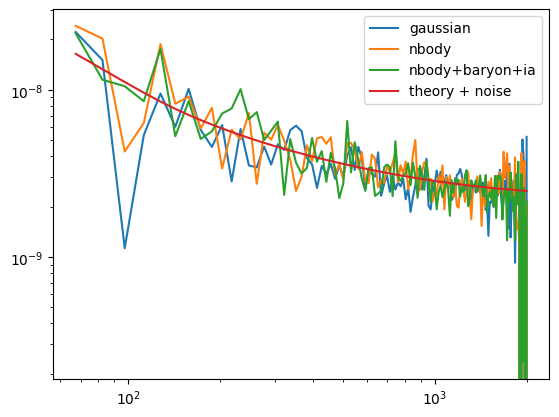

In [67]:
plt.loglog(ell,ps, label ='gaussian')
plt.loglog(ell2, ps2, label ='nbody')
plt.loglog(ell3, ps3, label ='nbody+baryon+ia')
plt.loglog(ell, Cl_theo[0], label ='theory + noise')
plt.legend()

In [72]:
def augmentation_noise(
        example, sigma_e=sigma_e, galaxy_density=galaxy_density, field_size=field_size, field_npix=field_npix
    ):

        
        y = example["map_nbody"]
        y += tf.random.normal(
            shape=(field_npix, field_npix),
            stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2),
        )
    

        return { "map_nbody": y, 'theta':example['theta']}
    
ds_tr = tfds.load("CosmogridGridFiducialDataset/fiducial", split="train")

ds_tr = ds_tr.repeat()
ds_tr = ds_tr.shuffle(800)
ds_tr = ds_tr.map(augmentation_noise)
ds_tr = ds_tr.batch(500)
ds_tr = ds_tr.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds_tr))

In [73]:
ex = next(ds_train)

In [83]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

nb = 45 # because it is at fixed cosmo

l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
map_size=10

ell2 = ConvergenceMap(ex['map_nbody'][0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[0]
ps2 = []
for i in range(nb):
    ps2.append(ConvergenceMap(ex['map_nbody'][i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)[1])
ps2 = np.mean(ps2, axis =0)
std2 = np.std(ps2, axis =0)

In [84]:
cosmo = jc.Planck15(
    Omega_c=ex['theta'][0][0] - ex['theta'][0][-1],
    Omega_b=ex['theta'][0][-1],
    h=ex['theta'][0][3] / 100,
    n_s=ex['theta'][0][4],
    sigma8=ex['theta'][0][1],
    Omega_k=0.0,
    w0=ex['theta'][0][2],
    wa=0.0,
)

nz_bins = jc.redshift.smail_nz(3.53, 4.49, 1.03, gals_per_arcmin2=10/4)
tracer = jc.probes.WeakLensing([nz_bins], sigma_e=sigma_e)

cell_theory = jc.angular_cl.angular_cl(cosmo, ell, [tracer])
cell_noise = jc.angular_cl.noise_cl(ell, [tracer])
Cl_theo = cell_theory + cell_noise

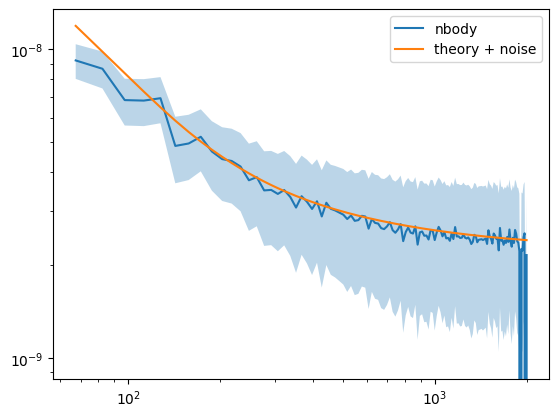

In [85]:
plt.loglog(ell2, ps2, label ='nbody')
plt.fill_between(ell2, ps2+1 *std2, ps2-1 *std2,  alpha=0.3)
plt.loglog(ell, Cl_theo[0], label ='theory + noise')
plt.legend()